In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['schema_name'] = "anix_nnfabrik_bias_transfer_adv_noise"
# dj.config['schema_name'] = "anix_nnfabrik_bias_transfer_test"

import matplotlib.pyplot as plt
import numpy as np
from bias_transfer.dataset import dataset_loader
from bias_transfer.config import *
from bias_transfer.trainer import trainer
from bias_transfer.models import resnet_builder
from bias_transfer.analysis import *
from bias_transfer.main import *


from bias_transfer.tables.base import *
from bias_transfer.tables.transfer import *
import nnfabrik as nnf
# nnf.config['repos'] = ['/notebooks/nnfabrik']
from nnfabrik.main import *
schema

Connecting anix@sinzlab.chlkmukhxp6i.eu-central-1.rds.amazonaws.com:3306


Schema `anix_nnfabrik_bias_transfer_adv_noise`

In [15]:
# noise="noise_snr_1.0_0.9.None_0.1"
# noise="noise_snr_1.0_1.0"
# noise="noise_snr_1.0_0.5.None_0.5"
# noise="noise_std_0.5_0.5.None_0.5"
noise="noise_std_0.08_0.1.0.12_0.1.0.18_0.1.0.26_0.1.0.38_0.1.None_0.5"
# noise="noise_std_0.08_0.2.0.12_0.2.0.18_0.2.0.26_0.2.0.38_0.2"

In [16]:
t1 = (ConfigToTrain() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}".format(noise=noise)},
                        {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8".format(noise=noise)},
                        {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13".format(noise=noise)},
                  {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8"} ,
                  {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8"} ,
                  {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13"} ,
                       ]).proj(c_comment="comment") * TrainedModel()

In [17]:
t2 = (ConfigToTrainAndTransfer() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

In [18]:
t3 = (ConfigToTrainAndTransfer() & [{"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                                    {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()

In [19]:
t4 = (ConfigToTrainAndTransfer2() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_classification_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.noise_adv_regression_True.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer".format(noise=noise)}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer".format(noise=noise)}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer".format(noise=noise)}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.transfer_True.freeze_True.transfer"}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8.transfer_True.freeze_True.transfer"}, 
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13.transfer_True.freeze_True.transfer"}, 
                   ]).proj(c_comment="comment") * TrainedTransferModel2()


In [20]:
t5 = (ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel()


In [21]:
t6 = (ConfigToTrainAndTransfer() & [
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_8\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_8.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                               {"comment":"optimizer_Adam.lr_0.0003.lr_decay_0.8.seed_13\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.seed_13.transfer_True.freeze_('readout',).transfer".format(noise=noise)},
                   ]).proj(c_comment="comment") * TrainedTransferModel2()

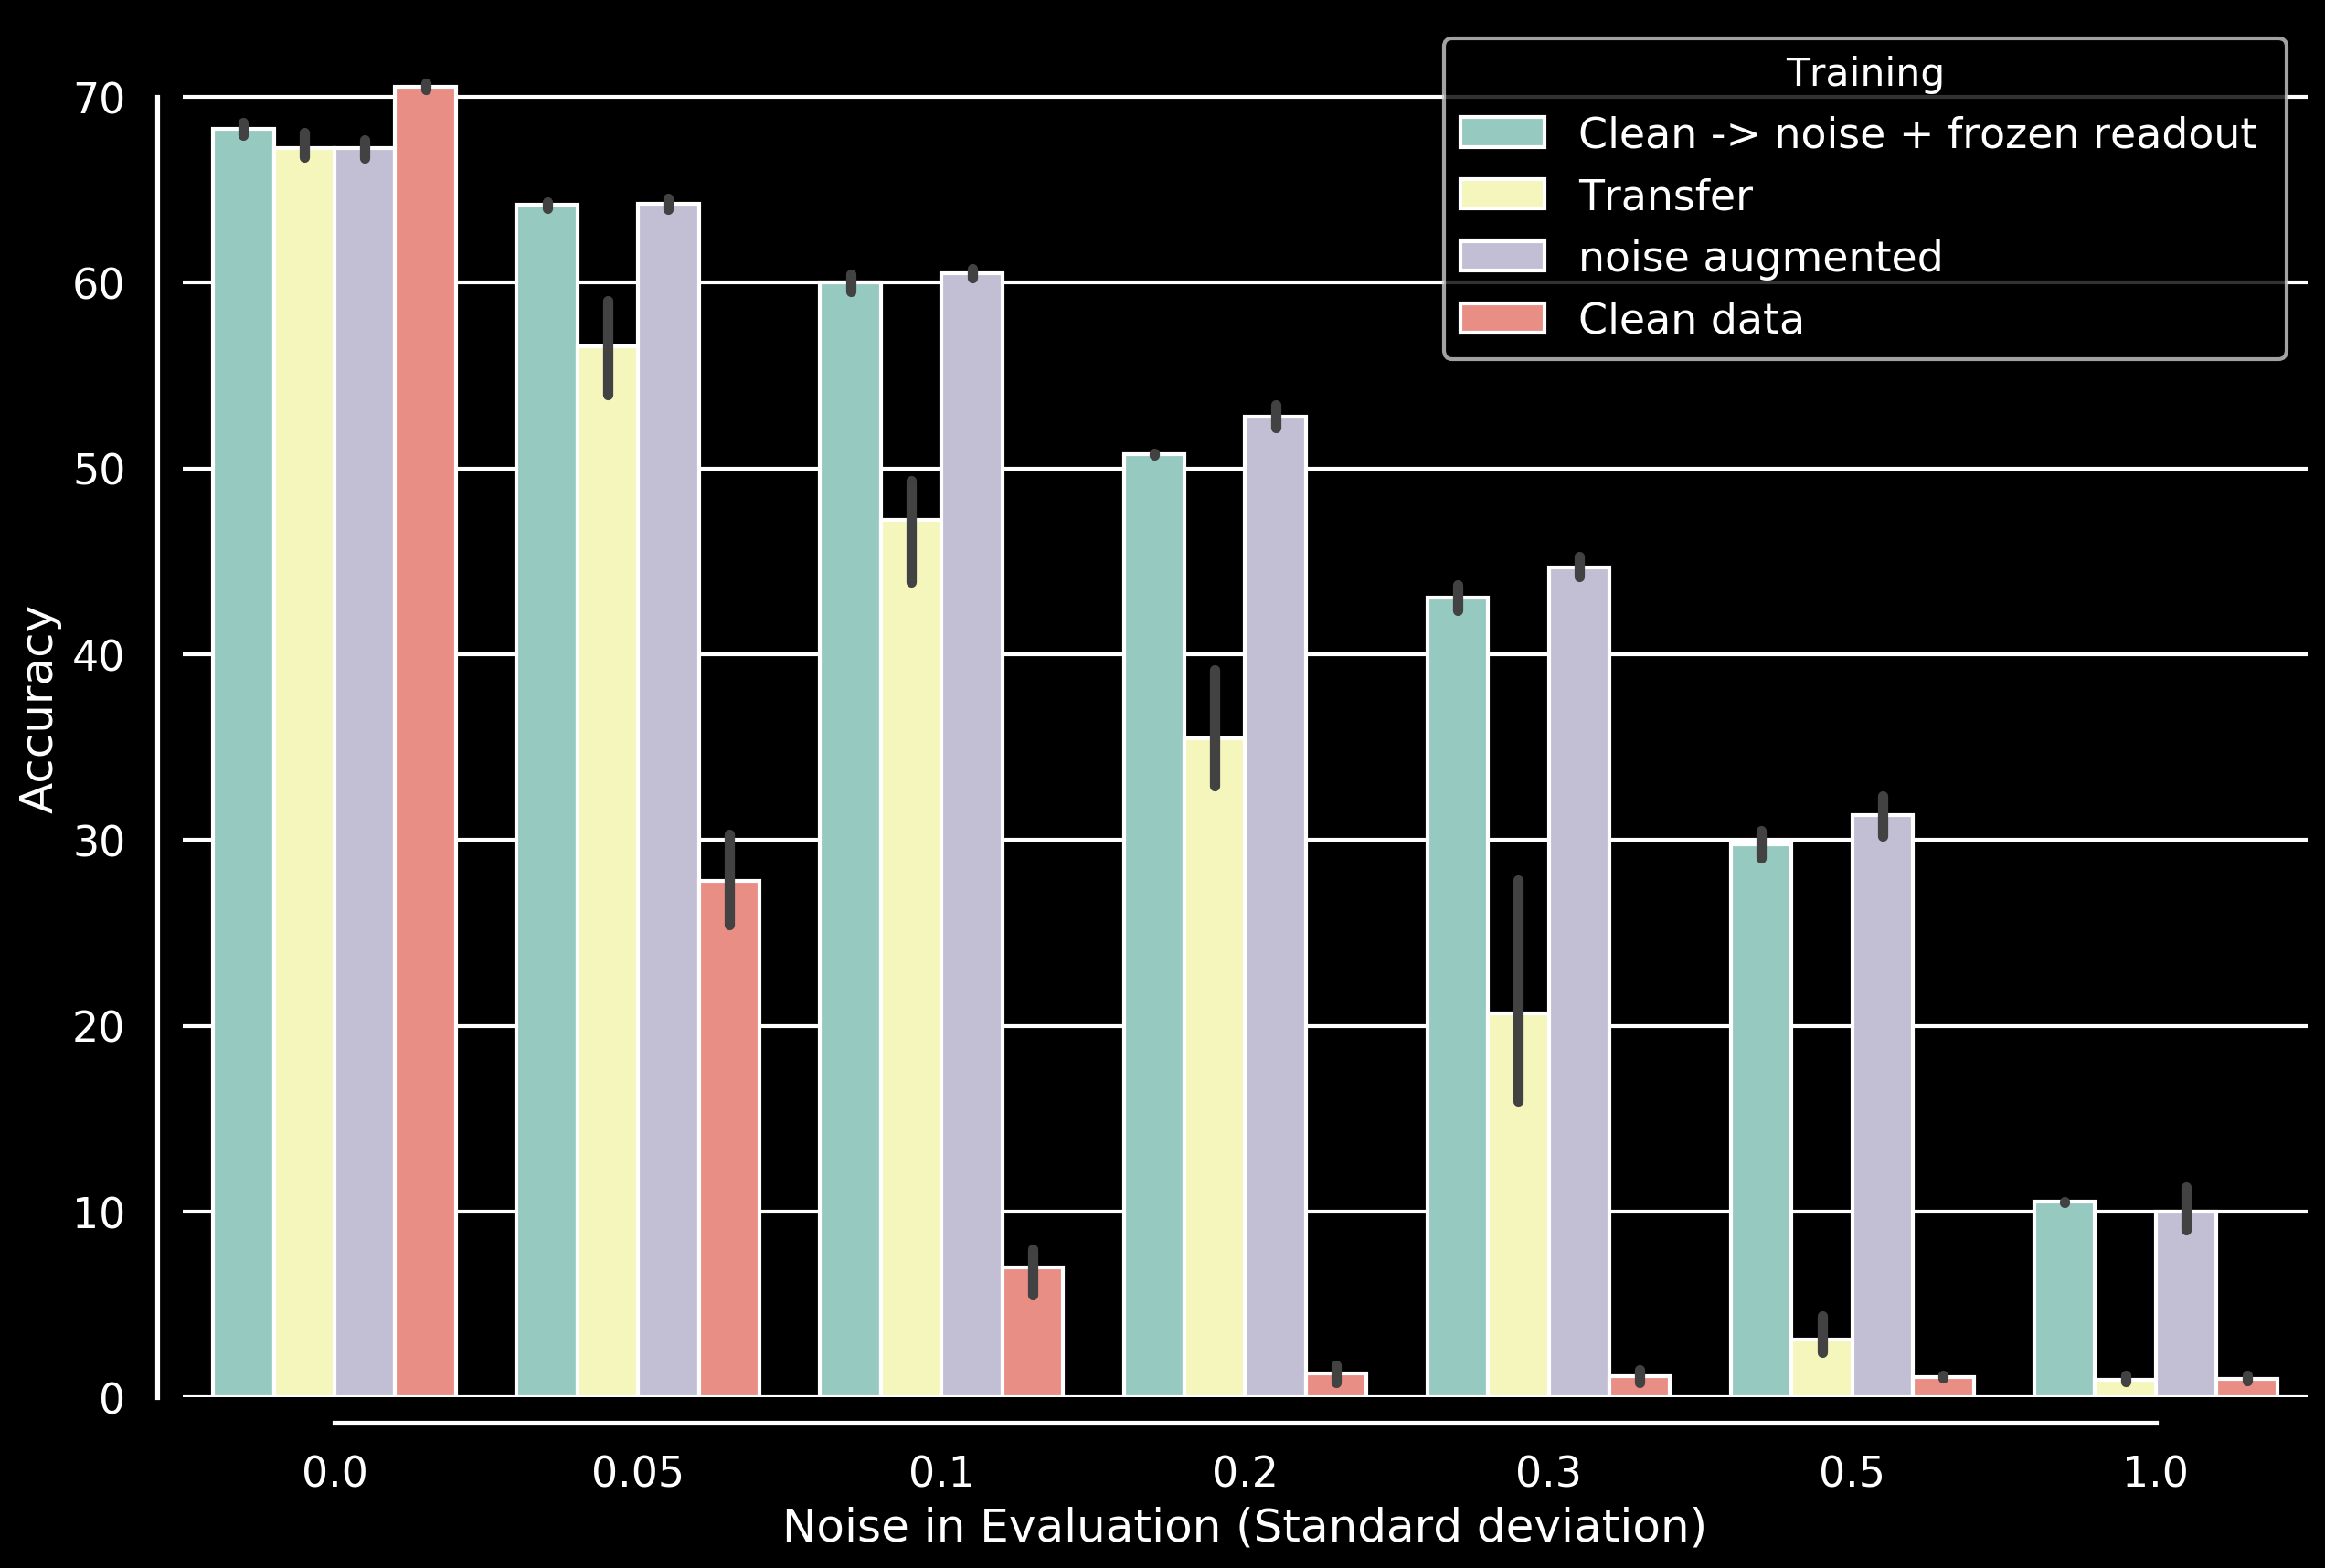

In [22]:
a = Analyzer(tables=(t1,t2,t5,t6), 
           comment_map={
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.None_0.5\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8.freeze_True\nresnet50.100\nCIFAR100.128".format(noise=noise): "Transfer long",
                        "adv_classification": "Transfer Class",
                        "adv_regression": "Transfer Regress",
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}.resnet50.100.CIFAR100.128".format(noise=noise): "noise augmented",
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8\nresnet50.100\nCIFAR100.128":"Clean long",
                        "optimizer_Adam.lr_0.0003.lr_decay_0.8.add_noise_True.{noise}\nresnet50.100\nCIFAR100.128\noptimizer_Adam.lr_0.0003.lr_decay_0.8.freeze_True\nresnet50.100\nCIFAR100.128".format(noise=noise) : "Transfer",
                       "optimizer_Adam.lr_0.0003.lr_decay_0.8.resnet50.100.CIFAR100.128": "Clean data", 
                       "freeze_('core',)": "Clean -> noise + frozen readout -> Transfer ", 
                       "freeze_('readout',)": "Clean -> noise + frozen readout ", 
                       },
            )
fig, ax = a.plot(to_plot="dev_noise_acc", 
       noise_measure="std",
       kind=None, 
       plot_method=sns.barplot,
        save="transfer_noise_adv_with_pretrain_"+noise+".png"
       )
# a.plot( #to_plot="dev_noise_acc", 
#         to_plot="training_progress", 
#        noise_measure="std",
#        kind=None, 
# #        plot_method=sns.barplot,
#        plot_method=sns.lineplot,
# #        save="inductive_bias_"+noise+".png"
#        )                             